# Food Hazard Multi-task BERT

Notebook baru dengan perbaikan: class weights untuk imbalance, scheduler dengan warmup, early stopping, dan epoch lebih panjang. Gunakan GPU jika tersedia.

In [1]:
# Install library (opsional jika sudah ada)
!pip install transformers scikit-learn pandas torch tqdm

In [2]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [3]:
# Load data
train_url = "https://raw.githubusercontent.com/food-hazard-detection-semeval-2025/food-hazard-detection-semeval-2025.github.io/refs/heads/main/data/incidents_train.csv"
valid_url = "https://raw.githubusercontent.com/food-hazard-detection-semeval-2025/food-hazard-detection-semeval-2025.github.io/refs/heads/main/data/incidents_valid.csv"
test_url = "https://raw.githubusercontent.com/food-hazard-detection-semeval-2025/food-hazard-detection-semeval-2025.github.io/refs/heads/main/data/incidents_test.csv"

df_train = pd.read_csv(train_url).fillna('')
df_valid = pd.read_csv(valid_url).fillna('')
df_test = pd.read_csv(test_url).fillna('')

print(f"Train: {len(df_train)}, Valid: {len(df_valid)}, Test: {len(df_test)}")
df_train.head()

Train: 5082, Valid: 565, Test: 997


,Unnamed: 0,year,month,day,country,title,text,hazard-category,product-category,hazard,product
0,0,1994,1,7,us,Recall Notification: FSIS-024-94,Case Number: 024-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,smoked sausage
1,1,1994,3,10,us,Recall Notification: FSIS-033-94,Case Number: 033-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria spp,sausage
2,2,1994,3,28,us,Recall Notification: FSIS-014-94,Case Number: 014-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,ham slices
3,3,1994,4,3,us,Recall Notification: FSIS-009-94,Case Number: 009-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,thermal processed pork meat
4,4,1994,7,1,us,Recall Notification: FSIS-001-94,Case Number: 001-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,chicken breast


In [9]:
# Encode labels dan hitung class weights
hazard_encoder = LabelEncoder()
product_encoder = LabelEncoder()

all_hazards = pd.concat([df_train['hazard-category'], df_valid['hazard-category'], df_test['hazard-category']]).unique()
all_products = pd.concat([df_train['product-category'], df_valid['product-category'], df_test['product-category']]).unique()

hazard_encoder.fit(all_hazards)
product_encoder.fit(all_products)

def encode_labels(df):
    df = df.copy()
    df['hazard_label'] = hazard_encoder.transform(df['hazard-category'])
    df['product_label'] = product_encoder.transform(df['product-category'])
    return df

df_train = encode_labels(df_train)
df_valid = encode_labels(df_valid)
df_test = encode_labels(df_test)

num_hazard_classes = len(hazard_encoder.classes_)
num_product_classes = len(product_encoder.classes_)
print(f"Hazard classes: {num_hazard_classes}, Product classes: {num_product_classes}")

# Compute class weights (balanced)
hazard_weights = compute_class_weight(class_weight='balanced', classes=np.arange(num_hazard_classes), y=df_train['hazard_label'])
product_weights = compute_class_weight(class_weight='balanced', classes=np.arange(num_product_classes), y=df_train['product_label'])

hazard_weights = torch.tensor(hazard_weights, dtype=torch.float32).to(device)
product_weights = torch.tensor(product_weights, dtype=torch.float32).to(device)
print("Hazard weights sample:", hazard_weights[:5])
print("Product weights sample:", product_weights[:5])

Hazard classes: 10, Product classes: 22
Hazard weights sample: tensor([ 0.2741,  0.2919,  1.7707, 21.1750,  0.9059], device='cuda:0')
Product weights sample: tensor([3.9153, 0.3443, 1.1000, 1.3588, 1.7634], device='cuda:0')


In [10]:
# Dataset dan DataLoader
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 256  # naikkan panjang konteks untuk menangkap detail lebih banyak

class FoodHazardDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        title = str(self.data.iloc[index]['title'])
        inputs = self.tokenizer.encode_plus(
            title,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs['token_type_ids'].flatten(),
            'hazard_label': torch.tensor(self.data.iloc[index]['hazard_label'], dtype=torch.long),
            'product_label': torch.tensor(self.data.iloc[index]['product_label'], dtype=torch.long)
        }

BATCH_SIZE = 16
train_loader = DataLoader(FoodHazardDataset(df_train, tokenizer, MAX_LEN), batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(FoodHazardDataset(df_valid, tokenizer, MAX_LEN), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(FoodHazardDataset(df_test, tokenizer, MAX_LEN), batch_size=BATCH_SIZE, shuffle=False)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
# Model multitask
class MultiTaskBERT(nn.Module):
    def __init__(self, num_hazard_classes, num_product_classes, dropout=0.2):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.drop = nn.Dropout(dropout)
        self.hazard_out = nn.Linear(768, num_hazard_classes)
        self.product_out = nn.Linear(768, num_product_classes)

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        pooled_output = outputs[1]
        output = self.drop(pooled_output)
        return self.hazard_out(output), self.product_out(output)

model = MultiTaskBERT(num_hazard_classes, num_product_classes).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# Optimizer, scheduler, dan loss dengan class weights
EPOCHS = 8
LR = 2e-5
WEIGHT_DECAY = 0.01

optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
total_steps = len(train_loader) * EPOCHS
warmup_steps = int(0.1 * total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

criterion_hazard = nn.CrossEntropyLoss(weight=hazard_weights)
criterion_product = nn.CrossEntropyLoss(weight=product_weights)

In [ ]:
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0

    for batch in tqdm(data_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        hazard_labels = batch['hazard_label'].to(device)
        product_labels = batch['product_label'].to(device)

        optimizer.zero_grad()
        hazard_logits, product_logits = model(input_ids, attention_mask, token_type_ids)

        loss_h = criterion_hazard(hazard_logits, hazard_labels)
        loss_p = criterion_product(product_logits, product_labels)
        loss = loss_h + loss_p

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)


def eval_model(model, data_loader, device):
    model.eval()
    h_true, h_pred, p_true, p_pred = [], [], [], []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            hazard_labels = batch['hazard_label']
            product_labels = batch['product_label']

            hazard_logits, product_logits = model(input_ids, attention_mask, token_type_ids)
            h_pred_batch = hazard_logits.argmax(dim=1).cpu().numpy()
            p_pred_batch = product_logits.argmax(dim=1).cpu().numpy()

            h_true.extend(hazard_labels.numpy())
            h_pred.extend(h_pred_batch)
            p_true.extend(product_labels.numpy())
            p_pred.extend(p_pred_batch)

    f1_h = f1_score(h_true, h_pred, average='macro')
    f1_p = f1_score(p_true, p_pred, average='macro')
    return f1_h, f1_p


def evaluate_and_print(epoch, model, loader):
    f1_h, f1_p = eval_model(model, loader, device)
    avg_f1 = (f1_h + f1_p) / 2
    print(f"Val Hazard Macro F1 : {f1_h:.4f}")
    print(f"Val Product Macro F1: {f1_p:.4f}")
    print(f"Combined Macro F1   : {avg_f1:.4f}")
    return avg_f1

In [ ]:
# Training loop dengan early stopping berbasis combined macro F1
BEST_PATH = "best_multitask_bert.pt"
patience = 2
best_f1 = 0.0
no_improve = 0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-" * 10)
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
    print(f"Train Loss: {train_loss:.4f}")

    val_f1 = evaluate_and_print(epoch, model, valid_loader)

    if val_f1 > best_f1:
        best_f1 = val_f1
        no_improve = 0
        torch.save(model.state_dict(), BEST_PATH)
        print("Saved new best model")
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered")
            break

# Load best checkpoint
if os.path.exists(BEST_PATH):
    model.load_state_dict(torch.load(BEST_PATH, map_location=device))
    print(f"Loaded best model with val combined F1 {best_f1:.4f}")



Epoch 1/8
----------


Training: 100%|██████████| 318/318 [03:28<00:00,  1.52it/s]


Train Loss: 5.1489
Val Hazard Macro F1 : 0.3708
Val Product Macro F1: 0.1744
Combined Macro F1   : 0.2726
Saved new best model

Epoch 2/8
----------


Training: 100%|██████████| 318/318 [03:29<00:00,  1.52it/s]


Train Loss: 3.7313
Val Hazard Macro F1 : 0.6057
Val Product Macro F1: 0.4967
Combined Macro F1   : 0.5512
Saved new best model

Epoch 3/8
----------


Training: 100%|██████████| 318/318 [03:29<00:00,  1.52it/s]


Train Loss: 2.7637
Val Hazard Macro F1 : 0.6294
Val Product Macro F1: 0.5529
Combined Macro F1   : 0.5912
Saved new best model

Epoch 4/8
----------


Training: 100%|██████████| 318/318 [03:29<00:00,  1.52it/s]


Train Loss: 2.1449
Val Hazard Macro F1 : 0.6813
Val Product Macro F1: 0.6069
Combined Macro F1   : 0.6441
Saved new best model

Epoch 5/8
----------


Training: 100%|██████████| 318/318 [03:29<00:00,  1.52it/s]


Train Loss: 1.7425
Val Hazard Macro F1 : 0.6819
Val Product Macro F1: 0.6232
Combined Macro F1   : 0.6526
Saved new best model

Epoch 6/8
----------


Training: 100%|██████████| 318/318 [03:29<00:00,  1.52it/s]


Train Loss: 1.4737
Val Hazard Macro F1 : 0.7053
Val Product Macro F1: 0.6291
Combined Macro F1   : 0.6672
Saved new best model

Epoch 7/8
----------


Training: 100%|██████████| 318/318 [03:29<00:00,  1.52it/s]


Train Loss: 1.2618
Val Hazard Macro F1 : 0.7052
Val Product Macro F1: 0.6313
Combined Macro F1   : 0.6683
Saved new best model

Epoch 8/8
----------


Training: 100%|██████████| 318/318 [03:29<00:00,  1.52it/s]


Train Loss: 1.1647
Val Hazard Macro F1 : 0.7183
Val Product Macro F1: 0.6397
Combined Macro F1   : 0.6790
Saved new best model
Loaded best model with val combined F1 0.6790


In [ ]:
# Final evaluation di test set
f1_h_test, f1_p_test = eval_model(model, test_loader, device)
avg_f1_test = (f1_h_test + f1_p_test) / 2

print("\n--- Final Evaluation on Test Set ---")
print(f"Test Hazard Macro F1 : {f1_h_test:.4f}")
print(f"Test Product Macro F1: {f1_p_test:.4f}")
print(f"Combined Macro F1    : {avg_f1_test:.4f}")

# Buat dataframe hasil
h_true, h_pred, p_true, p_pred = [], [], [], []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        hazard_labels = batch['hazard_label']
        product_labels = batch['product_label']
        hazard_logits, product_logits = model(input_ids, attention_mask, token_type_ids)
        h_pred.extend(hazard_logits.argmax(dim=1).cpu().numpy())
        p_pred.extend(product_logits.argmax(dim=1).cpu().numpy())
        h_true.extend(hazard_labels.numpy())
        p_true.extend(product_labels.numpy())

pred_hazard_text = hazard_encoder.inverse_transform(h_pred)
pred_product_text = product_encoder.inverse_transform(p_pred)

df_results = df_test.copy()
df_results['pred_hazard'] = pred_hazard_text
df_results['pred_product'] = pred_product_text
display(df_results[['title', 'hazard-category', 'pred_hazard', 'product-category', 'pred_product']].head(20))



--- Final Evaluation on Test Set ---
Test Hazard Macro F1 : 0.6043
Test Product Macro F1: 0.6544
Combined Macro F1    : 0.6293


,title,hazard-category,pred_hazard,product-category,pred_product
0,Recall Notification: FSIS-039-94,biological,biological,"meat, egg and dairy products","meat, egg and dairy products"
1,Recall Notification: FSIS-026-95,biological,biological,fruits and vegetables,"meat, egg and dairy products"
2,Recall Notification: FSIS-028-95,biological,biological,"meat, egg and dairy products","meat, egg and dairy products"
3,Black & Gold—Sliced Silverside 250g,biological,allergens,"meat, egg and dairy products",prepared dishes and snacks
4,Nestle—Peters—Neapolitan Ice Cream,foreign bodies,foreign bodies,ices and desserts,ices and desserts
5,Knispel Fruit Juices—Chilled Fruit Juice,biological,organoleptic aspects,non-alcoholic beverages,non-alcoholic beverages
6,Woolworths Limited—Cheese King baked ricotta,biological,biological,"meat, egg and dairy products","meat, egg and dairy products"
7,West Coast Halal Meat Specialists—Halal Sliced...,biological,biological,"meat, egg and dairy products","meat, egg and dairy products"
8,Leggos—Stir Through pasta sauces,foreign bodies,foreign bodies,"soups, broths, sauces and condiments","soups, broths, sauces and condiments"
9,Brisbane Fish Markets—Queenfish,chemical,chemical,seafood,seafood


In [15]:
#  MANUAL LOGS – AGAR TIDAK HILANG

epochs = list(range(1, 9))

train_loss = [5.1489, 3.7313, 2.7637, 2.1449, 1.7425, 1.4737, 1.2618, 1.1647]

val_hazard_f1 = [0.3708, 0.6057, 0.6294, 0.6813, 0.6819, 0.7053, 0.7052, 0.7183]
val_product_f1 = [0.1744, 0.4967, 0.5529, 0.6069, 0.6232, 0.6291, 0.6313, 0.6397]
combined_f1 = [0.2726, 0.5512, 0.5912, 0.6441, 0.6526, 0.6672, 0.6683, 0.6790]

# Final test results
test_results = {
    "Hazard Macro F1": 0.6043,
    "Product Macro F1": 0.6544,
    "Combined Macro F1": 0.6293
}


# Visualisasi

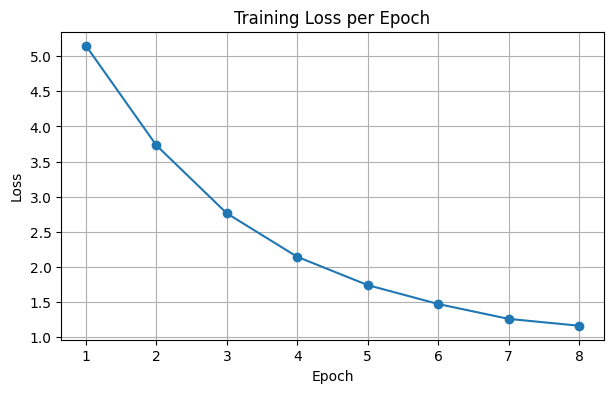

In [ ]:
# Grafik Training Loss

import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(epochs, train_loss, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


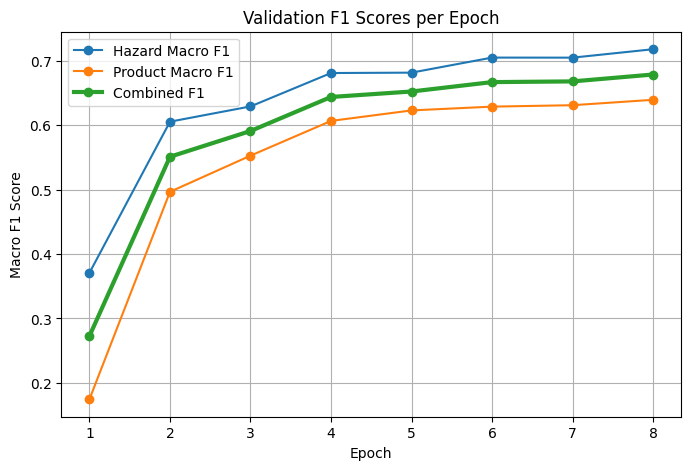

In [18]:
# Grafik Validation Macro F1

plt.figure(figsize=(8,5))
plt.plot(epochs, val_hazard_f1, marker='o', label="Hazard Macro F1")
plt.plot(epochs, val_product_f1, marker='o', label="Product Macro F1")
plt.plot(epochs, combined_f1, marker='o', label="Combined F1", linewidth=3)
plt.title("Validation F1 Scores per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Macro F1 Score")
plt.legend()
plt.grid(True)
plt.show()


In [29]:
# Tabel Training

df = pd.DataFrame({
    "Epoch": epochs,
    "Train Loss": train_loss,
    "Val Hazard F1": val_hazard_f1,
    "Val Product F1": val_product_f1,
    "Combined F1": combined_f1
})

df


,Epoch,Train Loss,Val Hazard F1,Val Product F1,Combined F1
0,1,5.1489,0.3708,0.1744,0.2726
1,2,3.7313,0.6057,0.4967,0.5512
2,3,2.7637,0.6294,0.5529,0.5912
3,4,2.1449,0.6813,0.6069,0.6441
4,5,1.7425,0.6819,0.6232,0.6526
5,6,1.4737,0.7053,0.6291,0.6672
6,7,1.2618,0.7052,0.6313,0.6683
7,8,1.1647,0.7183,0.6397,0.6790


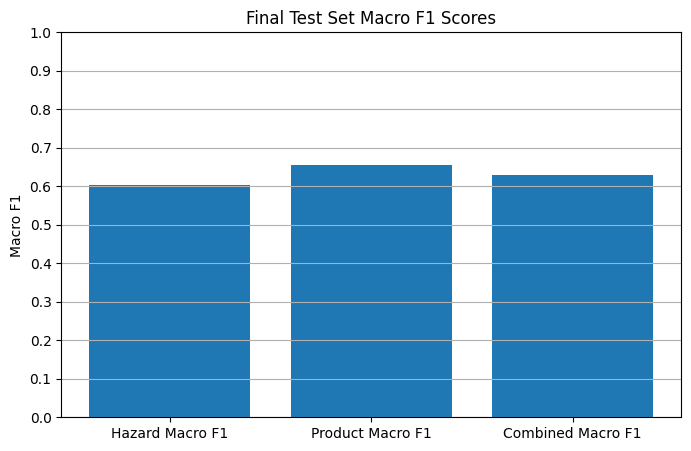

In [30]:
# Bar Chart untuk Hasil Test Akhir

plt.figure(figsize=(8,5))
plt.bar(test_results.keys(), test_results.values())
plt.title("Final Test Set Macro F1 Scores")
plt.ylabel("Macro F1")
plt.ylim(0,1)

# Atur step sumbu Y (0 sampai 1 dengan step 0.1)
plt.yticks(np.arange(0, 1.1, 0.1))

plt.grid(axis='y')
plt.show()

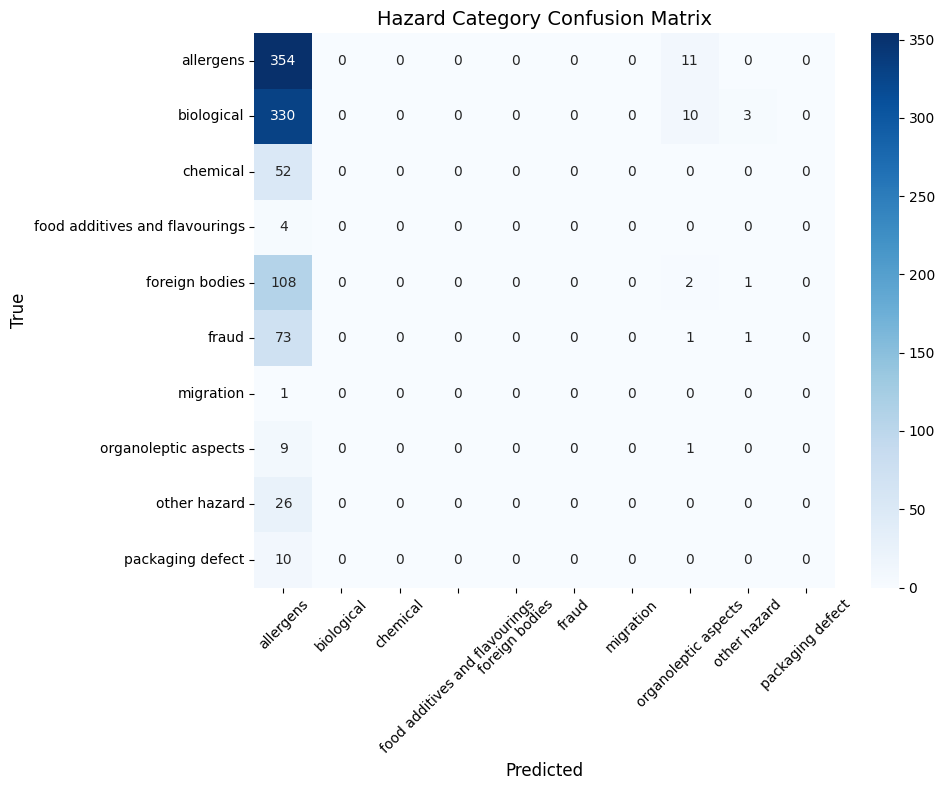

In [31]:
# Visualisasi Confusion Matrix

import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define BEST_PATH locally for robustness
BEST_PATH = "best_multitask_bert.pt"

# Ensure df_results contains prediction columns
# Re-run prediction logic and column assignment if 'pred_hazard' is not found
if 'pred_hazard' not in df_results.columns or 'pred_product' not in df_results.columns:
    print("Re-generating prediction columns for df_results...")
    # These variables (model, device, test_loader, hazard_encoder, product_encoder, df_test)
    # are assumed to be initialized from previous cells.

    # Re-initialize the model and load its best state dictionary
    # Ensure MultiTaskBERT class is defined (from previous cells)
    model = MultiTaskBERT(num_hazard_classes, num_product_classes).to(device)
    if os.path.exists(BEST_PATH):
        model.load_state_dict(torch.load(BEST_PATH, map_location=device))
        print(f"Loaded best model from {BEST_PATH}")
    else:
        print(f"Warning: Best model checkpoint not found at {BEST_PATH}. Using randomly initialized model.")

    h_pred_recreate, p_pred_recreate = [], []
    model.eval() # Ensure model is in evaluation mode
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            hazard_logits, product_logits = model(input_ids, attention_mask, token_type_ids)
            h_pred_recreate.extend(hazard_logits.argmax(dim=1).cpu().numpy())
            p_pred_recreate.extend(product_logits.argmax(dim=1).cpu().numpy())

    pred_hazard_text = hazard_encoder.inverse_transform(h_pred_recreate)
    pred_product_text = product_encoder.inverse_transform(p_pred_recreate)

    # Re-initialize df_results to ensure consistency, then add prediction columns
    df_results = df_test.copy()
    df_results['pred_hazard'] = pred_hazard_text
    df_results['pred_product'] = pred_product_text

# Ambil true & predicted labels langsung dari dataframe
true_hazard_labels = df_results["hazard-category"]
pred_hazard_labels = df_results["pred_hazard"]

# Ambil daftar kelas unik (agar label di heatmap sesuai kategori asli)
labels = sorted(df_results["hazard-category"].unique())

# Buat confusion matrix
cm = confusion_matrix(true_hazard_labels, pred_hazard_labels, labels=labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.title("Hazard Category Confusion Matrix", fontsize=14)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()